In [92]:
import rosbag2_py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from geopy.distance import geodesic
import folium
from scipy.ndimage import uniform_filter1d
import string
import seaborn as sns
from scipy.ndimage import uniform_filter1d
from scipy import stats

In [93]:
stationary_data_path = "lab1_ws/stationary.csv"
moving_data_path = "lab1_ws/stmoving.csv"

In [94]:
def read_df(path):
    df = pd.read_csv(path, header=None)
    df.columns = ['secs', 'nsecs', 'Frame_ID', 'latitude', 'longitude', 'altitude', 'utm_easting', 'utm_northing', 'zone', 'letter']
    return df

In [95]:
stationary_df = read_df(stationary_data_path)
moving_df = read_df(moving_data_path)

In [96]:
stationary_df

,secs,nsecs,Frame_ID,latitude,longitude,altitude,utm_easting,utm_northing,zone,letter
0,78663,0,GPS1_FRAME,42.337640,-71.087600,40.5,328023.301890,4.689376e+06,19,T
1,78664,0,GPS1_FRAME,42.337642,-71.087600,40.5,328023.306434,4.689376e+06,19,T
2,78665,0,GPS1_FRAME,42.337640,-71.087600,40.5,328023.301890,4.689376e+06,19,T
3,78666,0,GPS1_FRAME,42.337642,-71.087600,40.5,328023.306434,4.689376e+06,19,T
4,78667,0,GPS1_FRAME,42.337640,-71.087600,40.5,328023.301890,4.689376e+06,19,T
...,...,...,...,...,...,...,...,...,...,...
347,79010,0,GPS1_FRAME,42.337630,-71.087587,39.0,328024.373077,4.689375e+06,19,T
348,79011,0,GPS1_FRAME,42.337630,-71.087587,39.0,328024.373077,4.689375e+06,19,T
349,79012,0,GPS1_FRAME,42.337630,-71.087587,39.0,328024.373077,4.689375e+06,19,T
350,79013,0,GPS1_FRAME,42.337630,-71.087587,39.0,328024.373077,4.689375e+06,19,T


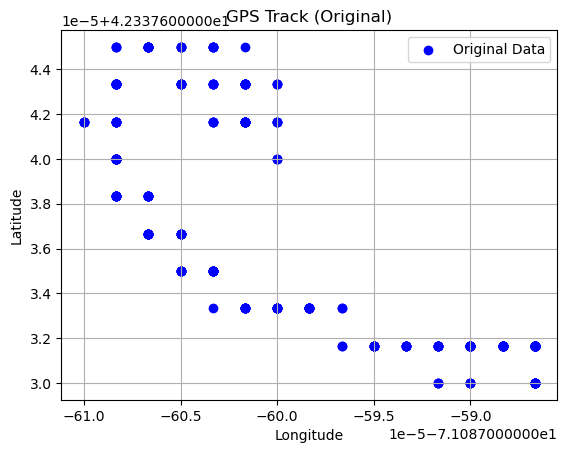

In [97]:
plt.scatter(stationary_df['longitude'], stationary_df['latitude'], c='blue', label='Original Data', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GPS Track (Original)')
plt.legend()
plt.grid(True)
plt.show()

### Analysis Functions

In [98]:
def check_latlong_accuracy(df):
    lat_std = np.std(df['latitude'])
    lon_std = np.std(df['longitude'])
    alt_std = np.std(df['altitude'])
    print(f'Standard Deviation -> Latitude: {lat_std}, Longitude: {lon_std}, Altitude: {alt_std}')

    #measured on google maps location
    gt_latitudes = 42.3376390
    gt_longitudes = -71.0875307
    lat_error = np.mean(np.abs(df['latitude'] - gt_latitudes))
    lon_error = np.mean(np.abs(df['longitude'] - gt_longitudes))
    print(f'Mean Error -> Latitude: {lat_error}, Longitude: {lon_error}')

In [99]:
def altitude_accuracy(df):
    rate_of_change = np.diff(df['altitude']) / np.diff(range(len(df['altitude'])))
    plt.plot(range(len(rate_of_change)), rate_of_change)  
    plt.xlabel('Time (s)')
    plt.ylabel('Rate of Change of Altitude (m/s)')
    plt.title('Rate of Change of Altitude')
    plt.show()
    rate_of_change = np.diff(df['altitude'].to_numpy()) / np.diff(range(len(df['altitude'].to_numpy())))
    print(f'Mean Rate of Change of Altitude: {np.mean(rate_of_change)}')

In [100]:
def plot_utm_coordinates(df):
    plt.scatter(df['utm_easting'], df['utm_northing'], c='green', marker='x')
    plt.xlabel('UTM Easting')
    plt.ylabel('UTM Northing')
    plt.title('UTM Coordinates Track')
    plt.grid(True)
    plt.show()

In [101]:
def distribution_check(df):
    fig, axes = plt.subplots(2, 2, figsize=(8, 10))

    sns.histplot(df['latitude'].to_numpy(), ax=axes[0, 0])
    axes[0, 0].set_title('Latitude Distribution')

    sns.histplot(df['longitude'].to_numpy(), ax=axes[0, 1])
    axes[0, 1].set_title('Longitude Distribution')

    sns.histplot(df['altitude'].to_numpy(), ax=axes[1, 0])
    axes[1, 0].set_title('Altitude Distribution')

    plt.show()

In [138]:
def utm_distribution_check(df):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5))

    sns.histplot(df['utm_easting'].to_numpy(), ax=axes[0])
    axes[0].set_title('UTM Easting Distribution')

    sns.histplot(df['utm_northing'].to_numpy(), ax=axes[1])
    axes[1].set_title('UTM Northing Distribution')

    plt.show()

In [124]:

def check_distribution_with_normal(df):
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))

    stats.probplot(df['latitude'].to_numpy(), dist="norm", plot=axes[0])
    axes[0].set_title("QQ Plot - Latitude")

    stats.probplot(df['longitude'].to_numpy(), dist="norm", plot=axes[1])
    axes[1].set_title("QQ Plot - Longitude")

    stats.probplot(df['altitude'].to_numpy(), dist="norm", plot=axes[2])
    axes[2].set_title("QQ Plot - Altitude")

    plt.tight_layout()
    plt.show()

In [134]:
def check_utm_distribution(df):
    fig, axes = plt.subplots(2, 1, figsize=(5, 10))

    stats.probplot(df['utm_easting'].to_numpy(), dist="norm", plot=axes[0])
    axes[0].set_title("QQ Plot - UTM Easting")

    stats.probplot(df['utm_northing'].to_numpy(), dist="norm", plot=axes[1])
    axes[1].set_title("QQ Plot - UTM Norhting")

    plt.tight_layout()
    plt.show()

In [105]:
def calculate_distance(df):
    total_distance = 0
    for i in range(1, len(df['latitude'])):
        coord1 = (df['latitude'][i-1], df['longitude'][i-1])
        coord2 = (df['latitude'][i], df['longitude'][i])
        total_distance += geodesic(coord1, coord2).meters
    return total_distance

In [106]:
def plot_on_map(df, title):
    map_center = [np.mean(df['latitude']), np.mean(df['longitude'])]
    m = folium.Map(location=map_center, zoom_start=14)

    for lat, lon in zip(df['latitude'], df['longitude']):
        folium.Marker([lat, lon]).add_to(m)

    m.save(title)
    print(f'Map saved as {title}')

## Stationary Data Analysis

as shown in this graph the stationary data had a very minor change in data with most of the data having the same value

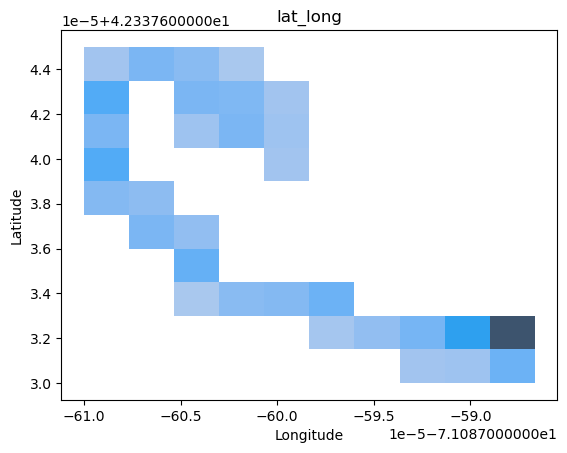

Standard Deviation -> Latitude: 5.100781315377349e-06, Longitude: 8.306288706385021e-06, Altitude: 0.5073322784978151
Mean Error -> Latitude: 5.211174245193946e-06, Longitude: 6.764753787737796e-05


In [107]:
# Plotting a line graph
sns.histplot(data=stationary_df, x='longitude', y='latitude')

# Adding title and labels
plt.title('lat_long')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show plot
plt.show()

check_latlong_accuracy(stationary_df)

Altitude data shows a constant change. The step change could indicate that it's a result of satalite changing positions or signal noise

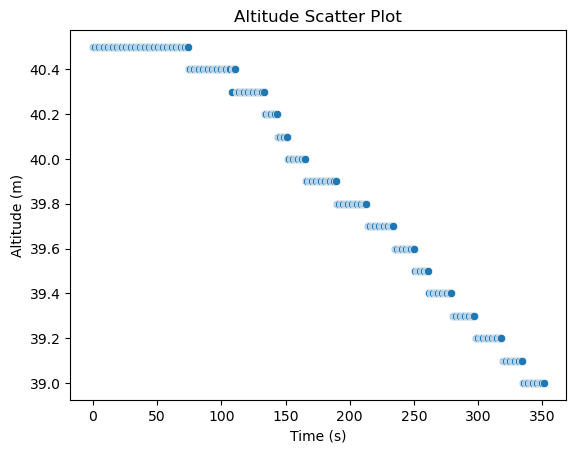

In [108]:

sns.scatterplot(x=range(len(stationary_df['altitude'])), y=stationary_df['altitude'])
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('Altitude Scatter Plot')
plt.show()


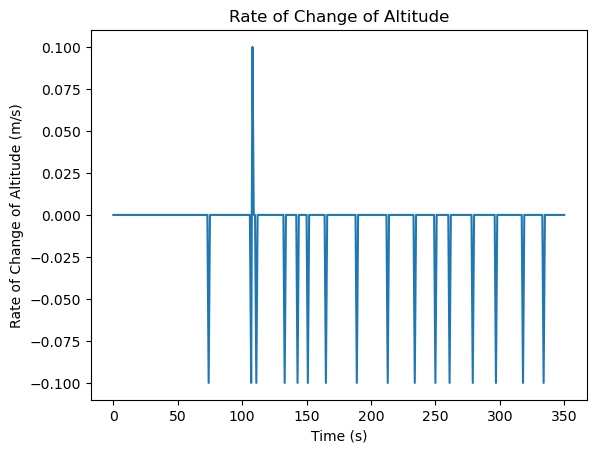

Mean Rate of Change of Altitude: -0.004273504273504274


In [109]:
altitude_accuracy(stationary_df)

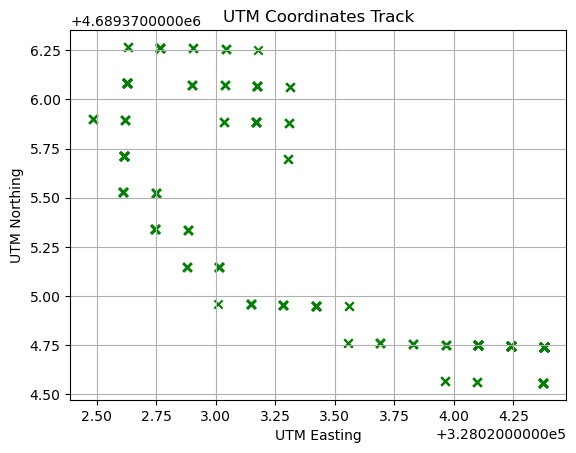

In [110]:
plot_utm_coordinates(stationary_df)

It shows that the GPS Puck has an inaccuracy of 7m

In [116]:
print(f'Total Distance: {calculate_distance(stationary_df)} m')

Total Distance: 7.181855260883217 m


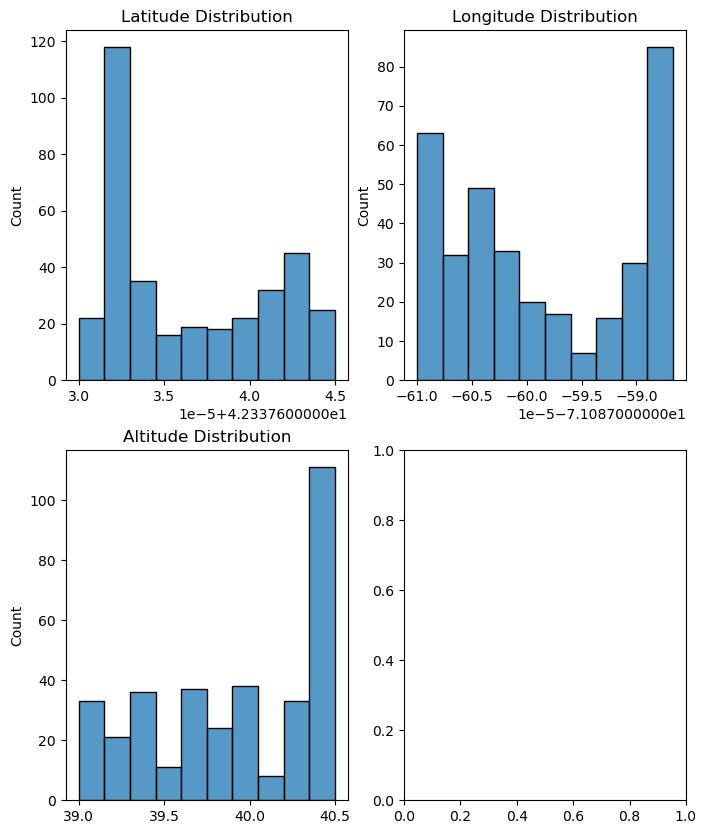

In [117]:
distribution_check(stationary_df)

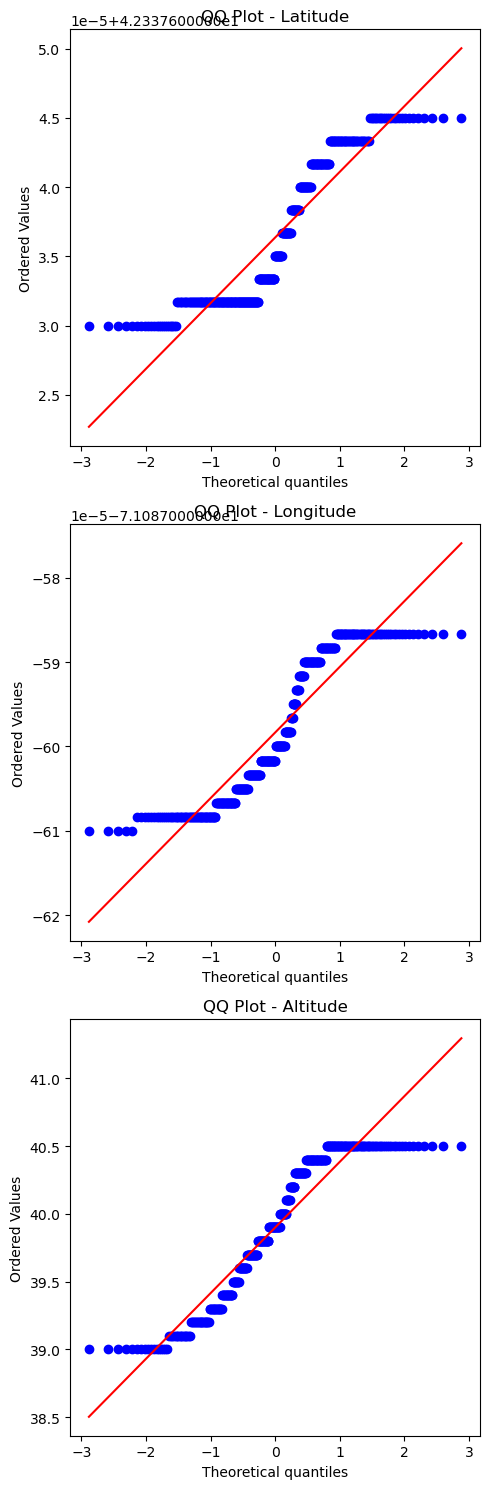

In [126]:
check_distribution_with_normal(stationary_df)

In [112]:
plot_on_map(stationary_df, 'stationary_map.html')

Map saved as stationary_map.html


## Moving data analysis

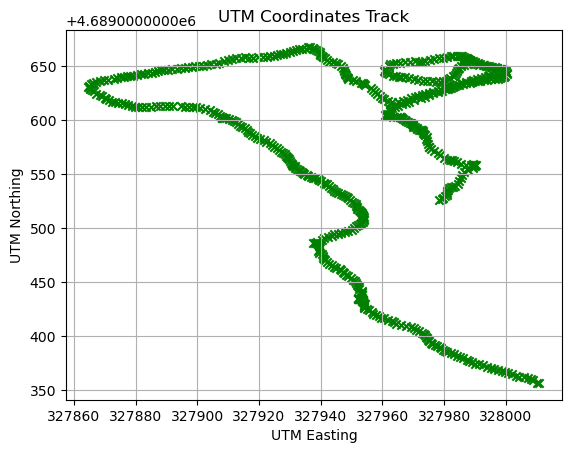

In [127]:
plot_utm_coordinates(moving_df)

In [129]:
def check_UTM_accuracy(df):
    lat_std = np.std(df['utm_easting'])
    lon_std = np.std(df['utm_northing'])
    print(f'Standard Deviation -> UTM Easting: {lat_std}, UTM Northing: {lon_std}')

check_UTM_accuracy(moving_df)

Standard Deviation -> UTM Easting: 34.4509797204328, UTM Northing: 87.58980972120033


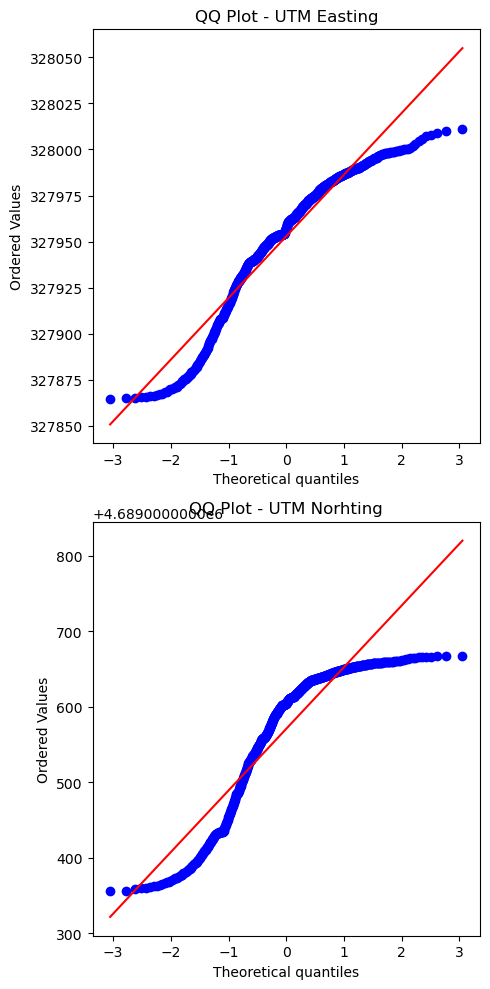

In [135]:
check_utm_distribution(moving_df)

In [137]:
distance_captured = calculate_distance(moving_df)
print(f'Total Distance: {distance_captured} m')
#calculated using Mapmyrun app
actual_distance = 824.3

print(f'Error in distance calculation: {np.abs(distance_captured - actual_distance)} m')

Total Distance: 825.3015519375773 m
Error in distance calculation: 1.0015519375773465 m


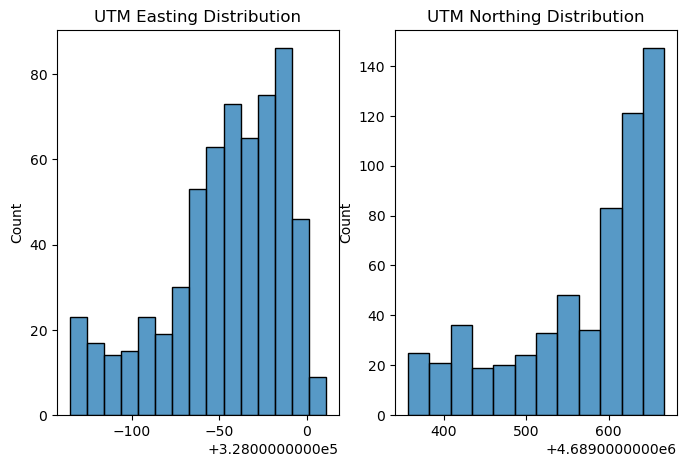

In [139]:
utm_distribution_check(moving_df)

In [140]:
plot_on_map(moving_df, 'moving_map.html')

Map saved as moving_map.html
